# pupil_new explanation (in detail)

This is a notebook on explaining every part of the pupil_new.py module

First, under `pipeline/python/pipeline`, you will find pupil_new.py file. This is the py file that contains the new table to be used for our automatic tracking.
The new schema name is called `pipeline_eye_DLC`. so let's import `pupil_new` first.
By the way, when you import, you will see whole bunch of backend warnings if you do so in notebook/lab (but not in ipython)... it is just a warning, not an error, so do not worry for now

In [1]:
import datajoint as dj
from pipeline import pupil_new

Loading local settings from pipeline_config.json
Connecting donnie@10.28.0.34:3306


/usr/local/lib/python3.6/dist-packages/deeplabcut/__init__.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/pla

DLC loaded in light mode; you cannot use the labeling GUI!
DLC loaded in light mode; you cannot use the relabeling GUI!


/usr/local/lib/python3.6/dist-packages/deeplabcut/utils/visualization.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/

OK, now let's see what is under `pupil_new` module. Simplest way of understanding this module is calling `dj.ERD`

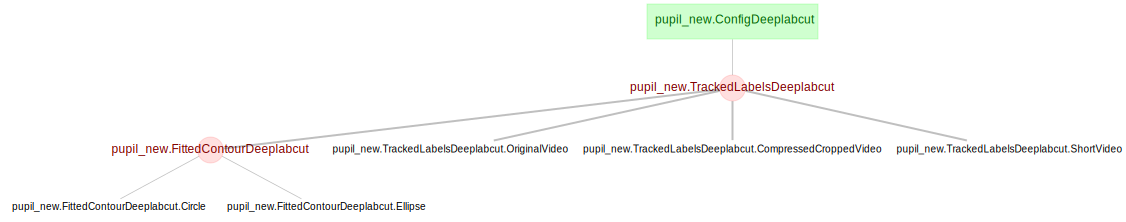

In [6]:
dj.ERD(pupil_new.schema)

Under this module there are 3 tables (1 `dj.Manual` and 2 `dj.Computed` with several part tables alongside):
1. ConfigDeeplabcut 
2. TrackedLabelsDeeplabcut
3. FittedContourDeeplabcut

let's look at `ConfigDeeplabcut` first

In [5]:
pupil_new.ConfigDeeplabcut()

config_path path to deeplabcut config,shuffle shuffle number used for the trained dlc model. Needed for dlc.analyze_videos,trainingsetindex trainingset index used for the trained dlc. model. Needed for dlc.analyze_videos
/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,1,0


In [5]:
pupil_new.ConfigDeeplabcut.heading

# Minimal info needed to load deeplabcut model
config_path          : varchar(255)                 # path to deeplabcut config
---
shuffle              : smallint unsigned            # shuffle number used for the trained dlc model. Needed for dlc.analyze_videos
trainingsetindex     : smallint unsigned            # trainingset index used for the trained dlc. model. Needed for dlc.analyze_videos

`ConfigDeeplabcut` is a table used to load configuration settings specific to DeepLabCut (DLC) model. Whenever we update our model for some reason (which is going to be me most likely), one needs to ensure that the new config path with appropriate shuffle and trainingsetindex is provided into this table.

For now, there is only one model (i.e. one model configuration), therefore only 1 entry.

Now let's look at `TrackedLabelsDeeplabcut`

In [9]:
pupil_new.TrackedLabelsDeeplabcut()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,config_path path to deeplabcut config,tracking_ts automatic,tracking_dir path to tracking directory
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,2019-04-12 15:10:14,/mnt/scratch06/Two-Photon/taliah/2019-02-07_12-31-03/20892_9_00010_beh_tracking
21608,1,19,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,2019-04-18 20:46:40,/mnt/scratch06/Two-Photon/taliah/2019-04-17_15-13-08/21608_1_00019_beh_tracking


In [10]:
pupil_new.TrackedLabelsDeeplabcut.heading

# Tracking table using deeplabcut
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
config_path          : varchar(255)                 # path to deeplabcut config
---
tracking_ts=CURRENT_TIMESTAMP : timestamp                    # automatic
tracking_dir         : varchar(255)                 # path to tracking directory

First thing first. `TrackedLabelsDeeplabcut` takes `ConfigDeeplabcut` as a foreign key (as you can see from `dj.ERD`)

Also, `TrackedLabelsDeeplabcut` is a complex table that performs the following:

1. Given a specific key (i.e. aniaml_id, session, scan_idx), it creates a needed directory structure by calling `create_tracking_directory`.
2. Make a 5 sec long short clip starting from the middle of the _original_ video via `make_short_video`
3. Using DLC model, predict/ find labels on short video via `predict_labels`
4. From the labels on short video, obtain coordinates to be used to _crop_ the original video via `obtain_cropping_coords`
5. Using the coordinates from step 4, crop and compress original video via `make_compressed_cropped_video`
6. Predict on `compressed_cropped_video`


I know it is alot to digest, so let's look at it one by one

### 1. Given a specific key (i.e. aniaml_id, session, scan_idx), it creates a needed directory structure by calling `create_tracking_directory`.

Let's call `create_tracking_directory?` and see what that does

In [12]:
pupil_new.TrackedLabelsDeeplabcut.create_tracking_directory?

Signature: pupil_new.TrackedLabelsDeeplabcut.create_tracking_directory(self, key)
Docstring:
this function creates the following directory structure:

video_original_dir
    |
    |------ video_original
    |------ tracking_dir (create_tracking_folder)
                |------- symlink to video_original (add_symlink) 
                |------- cropped_dir
                            |------- cropped_video (generated from make_short_video)
                            |------- h5 file for cropped video (generated by deeplabcut)
                            |------- pickle for cropped video (generated by deeplabcut)
                |------- short_dir
                            |------- short_video (generated by make_short_video function)
                            |------- h5 file for short video(generated by deeplabcut)
                            |------- pickle for short video (generated by deeplabcut)

Input:
    key: dictionary
        a dictionary that contains mouse id, session, and

Basically, given a specific video, it creates a tracking directory, add a symlink to the original video inside the tracking directory. Then it creates 2 sub direcotories, `short` and `compressed_cropped`. The reason we make such hierarchy is that 
1. we do not want to predict on the entire video, but only around the pupil area, hence we need to crop 
2. we want to compress the video (not over time but only over space) such that DLC can still predict reliably while reduce the size of the video 
3. In order to crop, we need to know where the pupil is, hence make a 5 sec long (or short video). Then using DLC model, find appropriate cropping coordinates.


One can actually see a real example by looking at case `20892_9_10`, one of the entires in the table

In [23]:
## Uncomment this cell to see

# import os
# key = dict(animal_id = 20892, session=9, scan_idx=10)
# tracking_dir = (pupil_new.TrackedLabelsDeeplabcut & key).fetch1('tracking_dir')
# print(os.listdir(tracking_dir))
# print(os.listdir(os.path.join(tracking_dir, 'short')))
# print(os.listdir(os.path.join(tracking_dir, 'compressed_cropped')))

.pickle and .h5 files are generated by DLC model and are used to predict labels. We will talk about it very soon, but for now, notice that under `tracking_dir`, we have the behavior video, `20892_9_10_beh.avi`. This is, however, _only_ a symlink to the actual video. Hence, even if we accidentally delete it, no harm to the actual video itself :) 

### 2. Make a 5 sec long short clip starting from the middle of the _original_ video via `make_short_video`

In [28]:
pupil_new.TrackedLabelsDeeplabcut.make_short_video??

Signature: pupil_new.TrackedLabelsDeeplabcut.make_short_video(self, tracking_dir)
Source:   
    def make_short_video(self, tracking_dir):
        """
        Extract 5 seconds long video starting from the middle of the original video.

        Input:
            tracking_dir: string
                String that specifies the full path of tracking directory
        Return:
            None
        """
        from subprocess import Popen, PIPE

        suffix = '_short.avi'

        case = os.path.basename(os.path.normpath(
            tracking_dir)).split('_tracking')[0]

        input_video_path = os.path.join(tracking_dir, case + '.avi')

        out_vid_path = os.path.join(tracking_dir, 'short', case + suffix)

        cap = cv2.VideoCapture(input_video_path)

        original_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        original_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

        fps = cap.get(cv2.CAP_PROP_FPS)
        mid_frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/2)


This function is quite straightforward. Using the symlink, we access the original video, then find the middle frame, which then is converted into actual time (in format of hr:min:sec). Then, using ffmpeg, we extract 5 second long video and save it under `short` directory

### 3. Using DLC model, predict/ find labels on short video via `predict_labels`

In [29]:
pupil_new.TrackedLabelsDeeplabcut.predict_labels?

Signature: pupil_new.TrackedLabelsDeeplabcut.predict_labels(self, vid_path, config)
Docstring: <no docstring>
File:      /data/pipeline/python/pipeline/pupil_new.py
Type:      function


### 4. From the labels on short video, obtain coordinates to be used to _crop_ the original video via `obtain_cropping_coords`

### 5. Using the coordinates from step 4, crop and compress original video via `make_compressed_cropped_video`

### 6. Predict on `compressed_cropped_video`